In [2]:
import numpy as np
import qutip as qt
import scipy as sc
import physical_constants as pc
import matplotlib as mpl
import matplotlib.colors as cl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pickle
mpl.rcParams.update({'font.size':20}) # This sometimes needs to be run twice to make it work

In [16]:
#
#   CSFQ Hamiltonian without BO approximation and negligible inductance.
#
def Hcsfq_nL(phi_x,phi_z,Ic,Cz,alpha,Csh,asy=0.0,Qms=None,Qps=None,Dt=None,Dms=None,Dps=None):

    # Asymmetry factor and phase
    asy_f = np.sqrt(1 + asy**2 * np.tan(phi_x/2)**2)
    asy_p = np.arctan(asy * np.tan(phi_x/2))
    
    # Slow charging energy (GHz)
    Em = 2*pc.e**2/((2*Csh + (4*alpha+1)*Cz)*pc.hbar) * 1e-9
    
    # Fast charging energy (GHz)
    Ep = 2*pc.e**2/(Cz*pc.hbar) * 1e-9
    
    # Josephson energy (GHz)
    Ej = Ic*pc.phi0/(2*np.pi*pc.hbar) * 1e-15 * 1e6
    
    # Construct Hamiltonian
    H = 0.5*Em*Qms + 0.5*Ep*Qps - 0.5*Ej*Dt + asy_f*alpha*Ej*np.cos(phi_x/2)*(np.exp(1j*(phi_z-asy_p))*Dps+np.exp(-1j*(phi_z-asy_p))*Dms)
    
    # Return relevant parts
    return H.data.todense()

#
# Create the operators for non-BO CSFQ
#

# Two Hilbert space truncators
truncm = 80
truncp = 11

# Charge operators
Qm = qt.num(truncm,-(truncm - 1)/2)
Qp = qt.num(truncp,-(truncp - 1)/2)

# Slow charge raising operator
Dm_p = qt.qeye(truncm) - qt.qeye(truncm)
for i in range(truncm-1):
    Dm_p += qt.basis(truncm,i)*qt.basis(truncm,i+1).dag()

# Slow charge lowering operator
Dm_m = Dm_p.dag()

# Fast charge raising operator
Dp_p = qt.qeye(truncp) - qt.qeye(truncp)
for i in range(truncp-1):
    Dp_p += qt.basis(truncp,i)*qt.basis(truncp,i+1).dag()

# Fast charge lowering operator
Dp_m = Dp_p.dag()

# Construct the operators in the extended Hilbert space
Qms = qt.tensor(Qm**2,qt.qeye(truncp))
Qps = qt.tensor(qt.qeye(truncm),Qp**2)
Dt = qt.tensor(Dm_p,Dp_p) + qt.tensor(Dm_m,Dp_m) + qt.tensor(Dm_m,Dp_p) + qt.tensor(Dm_p,Dp_m)
Dms = qt.tensor(Dm_m**2,qt.qeye(truncp))
Dps = qt.tensor(Dm_p**2,qt.qeye(truncp))

In [34]:
alpha1=0.461
Csh1 = 47e-15
Cz1 = 3.6e-15
asy1 = 0.1
Ic1 = 178.5e-9

In [17]:
# Gen data sets: non-BO
phiz = np.linspace(-0.2*np.pi,0.2*np.pi,21)
phix = np.linspace(-2*np.pi,2*np.pi,21)
Ex3 = [0.0]*21
Ez3 = [0.0]*21
for i,z in enumerate(phiz):
    E = np.linalg.eigvalsh(Hcsfq_nL(0.0,z,Ic1,Cz1,alpha1,Csh1,asy=asy1,Qms=Qms,Qps=Qps,Dt=Dt,Dms=Dms,Dps=Dps))
    Ez3[i] = E-E[0]
for i,x in enumerate(phix):
    E = np.linalg.eigvalsh(Hcsfq_nL(x,0.0,Ic1,Cz1,alpha1,Csh1,asy=asy1,Qms=Qms,Qps=Qps,Dt=Dt,Dms=Dms,Dps=Dps))
    Ex3[i] = E-E[0]
Ez3 = np.array(Ez3)
Ex3 = np.array(Ex3)

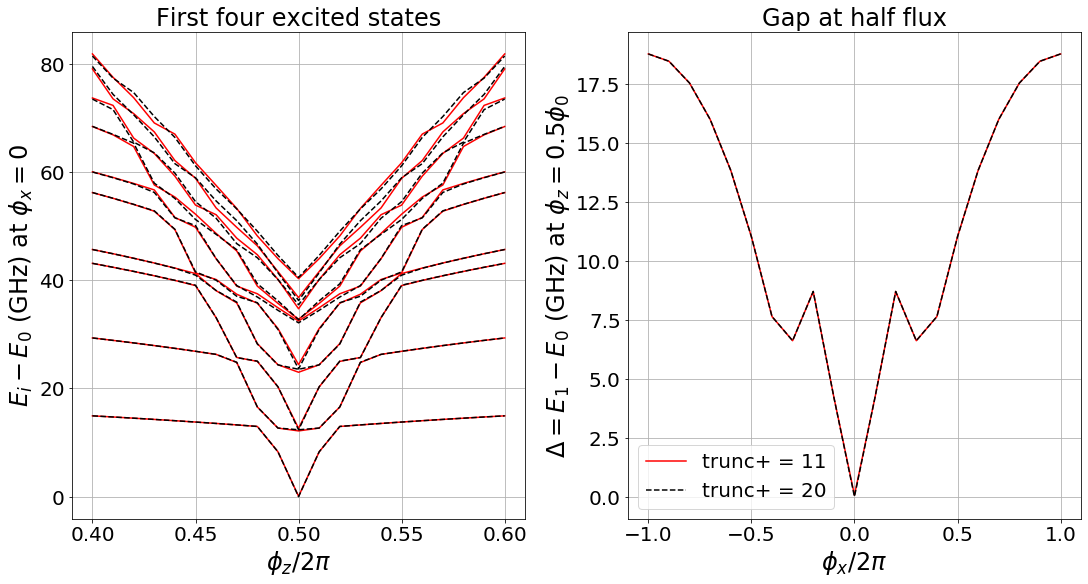

In [19]:
# Get figure and axis object
fig, ax = plt.subplots(1,2,constrained_layout=True,figsize=(15,8)) # WARNING! Experimental Feature that may break in the future
ax1 = ax[0]
ax2 = ax[1]

# Z dependence
for i in range(10):
    ax1.plot(phiz/(np.pi*2)+0.5, Ez3[:,2*i+2]/(2*np.pi),"r-")
    ax1.plot(phiz/(np.pi*2)+0.5, Ez2[:,2*i+2]/(2*np.pi),"k--")
ax1.set_xlabel('$\phi_z/2\pi$',fontsize="large")
ax1.set_ylabel('$E_i-E_0$ (GHz) at $\phi_x = 0$',fontsize="large")
ax1.grid()
ax1.set_title("First four excited states")

# X dependence
ax2.plot(phix/(np.pi*2), Ex3[:,2]/(2*np.pi),"r-",label="trunc+ = 11")
ax2.plot(phix/(np.pi*2), Ex2[:,2]/(2*np.pi),"k--",label="trunc+ = 20")
ax2.set_xlabel('$\phi_x/2\pi$',fontsize="large")
ax2.set_ylabel('$\Delta = E_1-E_0$ (GHz) at $\phi_z = 0.5\phi_0$',fontsize="large")
ax2.grid()
ax2.set_title("Gap at half flux")
ax2.legend()

# Save
plt.show()
plt.close()

In [35]:
# Gen data sets: non-BO
phiz = np.linspace(-0.055*2*np.pi,-0.02*2*np.pi,21)+np.pi
x = 0.640*2*np.pi
Ez11 = [0.0]*21
for i,z in enumerate(phiz):
    E = np.linalg.eigvalsh(Hcsfq_nL(x,z,Ic1,Cz1,alpha1,Csh1,asy=asy1,Qms=Qms,Qps=Qps,Dt=Dt,Dms=Dms,Dps=Dps))
    Ez11[i] = E-E[0]

x = 0.630*2*np.pi
Ez12 = [0.0]*21
for i,z in enumerate(phiz):
    E = np.linalg.eigvalsh(Hcsfq_nL(x,z,Ic1,Cz1,alpha1,Csh1,asy=asy1,Qms=Qms,Qps=Qps,Dt=Dt,Dms=Dms,Dps=Dps))
    Ez12[i] = E-E[0]

x = 0.620*2*np.pi
Ez13 = [0.0]*21
for i,z in enumerate(phiz):
    E = np.linalg.eigvalsh(Hcsfq_nL(x,z,Ic1,Cz1,alpha1,Csh1,asy=asy1,Qms=Qms,Qps=Qps,Dt=Dt,Dms=Dms,Dps=Dps))
    Ez13[i] = E-E[0]

Ez11 = np.array(Ez11)
Ez12 = np.array(Ez12)
Ez13 = np.array(Ez13)

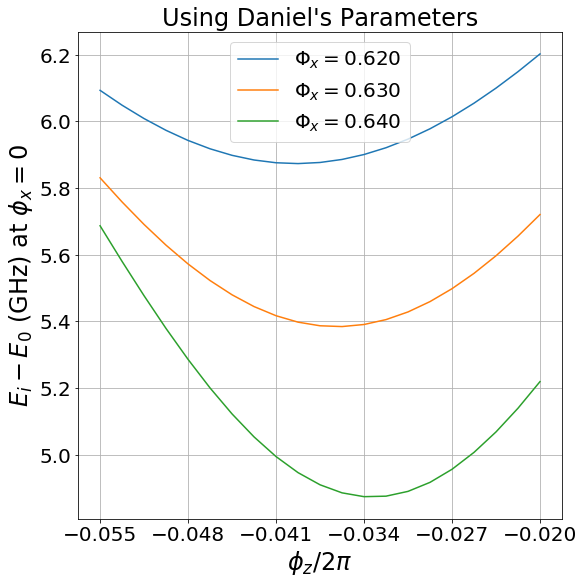

In [49]:
# Get figure and axis object
fig, ax1 = plt.subplots(1,1,constrained_layout=True,figsize=(8,8)) # WARNING! Experimental Feature that may break in the future

# Z dependence
ax1.plot(phiz/(np.pi*2)-0.5, Ez13[:,2]/(2*np.pi),label="$\\Phi_x = 0.620$")
ax1.plot(phiz/(np.pi*2)-0.5, Ez12[:,2]/(2*np.pi),label="$\\Phi_x = 0.630$")
ax1.plot(phiz/(np.pi*2)-0.5, Ez11[:,2]/(2*np.pi),label="$\\Phi_x = 0.640$")
ax1.set_xlabel('$\phi_z/2\pi$',fontsize="large")
ax1.set_ylabel('$E_i-E_0$ (GHz) at $\phi_x = 0$',fontsize="large")
ax1.grid()
ax1.set_title("Using Daniel's Parameters")
ax1.legend()
a = phiz/(np.pi*2)-0.5
ax1.set_xticks(a[::4])

# Save
plt.savefig("comparison.png")
plt.show()
plt.close()

In [50]:
def writebin(obj,filename):
    fd = open(filename,"wb")
    pickle.dump(obj,fd)
    fd.close()

obj = [
    phiz/(np.pi*2)-0.5,
    Ez13/(2*np.pi),
    Ez12/(2*np.pi),
    Ez11/(2*np.pi)
]

writebin(obj,"sim_data_daniel_values.bin")

In [51]:
import pickle
def readbin(filename):
    fd = open(filename,"rb")
    obj = pickle.load(fd)
    fd.close()
    return obj

pz, E1, E2, E3 = readbin("sim_data_daniel_values.bin")

In [52]:
pz

array([-0.055  , -0.05325, -0.0515 , -0.04975, -0.048  , -0.04625,
       -0.0445 , -0.04275, -0.041  , -0.03925, -0.0375 , -0.03575,
       -0.034  , -0.03225, -0.0305 , -0.02875, -0.027  , -0.02525,
       -0.0235 , -0.02175, -0.02   ])

In [53]:
E1

array([[0.00000000e+00, 1.26656755e-13, 6.09285000e+00, ...,
        9.95926989e+02, 9.95932099e+02, 9.95932099e+02],
       [0.00000000e+00, 3.61876444e-12, 6.04826571e+00, ...,
        9.95843493e+02, 9.95848605e+02, 9.95848605e+02],
       [0.00000000e+00, 4.23395439e-12, 6.00816849e+00, ...,
        9.95769270e+02, 9.95774384e+02, 9.95774384e+02],
       ...,
       [0.00000000e+00, 1.44750578e-13, 6.09953980e+00, ...,
        9.95939607e+02, 9.95944716e+02, 9.95944716e+02],
       [0.00000000e+00, 3.81779648e-12, 6.14888297e+00, ...,
        9.96033395e+02, 9.96038501e+02, 9.96038501e+02],
       [0.00000000e+00, 1.84556986e-12, 6.20205825e+00, ...,
        9.96135910e+02, 9.96141013e+02, 9.96141013e+02]])